In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Downloading Dataset

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor


transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root = './data',train = True,transform = ToTensor(),download = True,)
test_data = datasets.MNIST(root = './data',train = False,transform = ToTensor())

In [ ]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


Dataloader and printing the digits

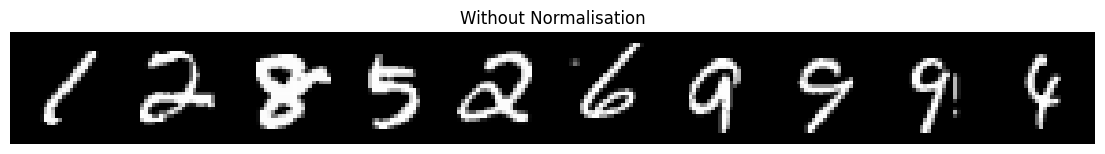

In [ ]:
#Generating data loaders from the corresponding datasets
batch_size = 256

#without normalisation
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

plt.rcParams['figure.figsize'] = 14, 6

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:10], normalize=True, padding=1, nrow=10).numpy(), (1, 2, 0)))
plt.axis('off')
plt.title('Without Normalisation')
plt.show()


CNN-Vanilla

In [ ]:
class CNNVanilla(nn.Module):
    def __init__(self, n_channels=8):
        super(CNNVanilla, self).__init__()

        self.n_channels = n_channels
        # --- Conv layer Set 1
        self.l1_conv = nn.Conv2d(in_channels=1,out_channels=n_channels,kernel_size=3,stride=1,padding=1,)
        self.l1_relu =  nn.ReLU()
        self.l1_pool =  nn.MaxPool2d(kernel_size=2)
        # --- Conv layer Set 2
        self.l2_conv = nn.Conv2d(n_channels, n_channels, 3, 1, 1)
        self.l2_relu =  nn.ReLU()
        self.l2_pool =  nn.MaxPool2d(kernel_size=2)
        # --- Conv layer Set 3
        self.l3_conv = nn.Conv2d(n_channels, n_channels, 3, 1, 1)
        self.l3_relu =  nn.ReLU()
        self.l3_pool =  nn.MaxPool2d(kernel_size=2)
        # --- Conv layer Set 4
        self.l4_conv = nn.Conv2d(n_channels, n_channels, 3, 1, 1)
        self.l4_relu =  nn.ReLU()
        self.l4_pool =  nn.MaxPool2d(kernel_size=2)
        # --- Conv layer Set 5
        self.l5_conv = nn.Conv2d(n_channels, n_channels, 3, 1, 1)
        self.l5_relu =  nn.ReLU()
        self.l5_pool =  nn.MaxPool2d(kernel_size=2)
        # --- FCL
        self.fc_flat = nn.Flatten()			# ------> Flatten ----->
        self.fc_lin1 = nn.Linear(n_channels * 3 * 3, 128)		#  ---------> Linear(512) ------>
        self.fc_relu = nn.ReLU()                #  ---------> ReLu ------->
        self.fc_lin2 = nn.Linear(128, 10)				# ----------> Linear(10) ------>


    def forward(self, x):
        x = self.l1_pool(self.l1_relu(self.l1_conv(x)))
        x = (self.l2_relu(self.l2_conv(x)))
        x = self.l3_pool(self.l3_relu(self.l3_conv(x)))
        x = (self.l4_relu(self.l4_conv(x)))
        x = self.l5_pool(self.l5_relu(self.l5_conv(x)))

        x = x.view(-1, self.n_channels * 3 * 3)
        x = self.fc_lin1(x)
        x = self.fc_relu(x)
        x = self.fc_lin2(x)
        return x    # return x for visualization

cnn = CNNVanilla()
print(cnn(images[0,:,:,:]).shape)

torch.Size([1, 10])


CNN-ResNet

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x = x + residual  # Shortcut connection
        x = self.relu(x)
        return x


In [ ]:
class CNN_ResNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, n_channels=8):
        self.n_channels = n_channels
        super(CNN_ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels=n_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.resnet1 = ResidualBlock(n_channels, n_channels)
        self.resnet2 = ResidualBlock(n_channels, n_channels)
        self.fc_flat = nn.Flatten()     # ------> Flatten ----->
        self.fc_lin1 = nn.Linear(n_channels * 3* 3, 128)   #  ---------> Linear(512) ------>
        self.fc_relu = nn.ReLU()                #  ---------> ReLu ------->
        self.fc_lin2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.pool(self.resnet1(x))
        x = self.pool(self.resnet2(x))
        x = x.view(-1, self.n_channels * 3 * 3)   #flatten
        x = self.fc_lin1(x)
        x = self.fc_relu(x)
        x = self.fc_lin2(x)
        return x

resnet = CNN_ResNet()
y_hat2 = resnet(images[0, :, :, :])
print(y_hat2.shape)

torch.Size([1, 10])


Defining Training and evalution loops

In [ ]:
def train(model, criterion, optimizer, trainloader, epochs):
    model.train()
    train_losses= []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}")
        train_losses.append(running_loss/len(train_loader))
    return train_losses

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")


In [ ]:
# Instantiate models
cnn_vanilla = CNNVanilla()
cnn_resnet = CNN_ResNet()

cnn_vanilla = cnn_vanilla.to('cuda')
cnn_resnet = cnn_resnet.to('cuda')

# Define loss function and optimizer
epochs=50
criterion = nn.CrossEntropyLoss()
optimizer_vanilla = optim.Adam(cnn_vanilla.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(cnn_resnet.parameters(), lr=0.001)

Summary of Models

In [ ]:
from torchsummary import summary
total_params = sum(p.numel() for p in cnn_vanilla.parameters())
print(f"Total number of parameters for CNN-Vanilla : {total_params}")
summary(cnn_vanilla,(1,28,28))
total_params = sum(p.numel() for p in cnn_resnet.parameters())
print(f"Total number of parameters for CNN-Resnet : {total_params}")
summary(cnn_resnet,(1,28,28))


Total number of parameters for CNN-Vanilla : 13050
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]             584
              ReLU-5            [-1, 8, 14, 14]               0
            Conv2d-6            [-1, 8, 14, 14]             584
              ReLU-7            [-1, 8, 14, 14]               0
         MaxPool2d-8              [-1, 8, 7, 7]               0
            Conv2d-9              [-1, 8, 7, 7]             584
             ReLU-10              [-1, 8, 7, 7]               0
           Conv2d-11              [-1, 8, 7, 7]             584
             ReLU-12              [-1, 8, 7, 7]               0
        MaxPool2d-13              [-1, 8, 3, 3]     

Train and evaluate CNN-Vanilla

Training CNN-Vanilla:
Epoch 1/50, Loss: 0.9761244615975847
Epoch 2/50, Loss: 0.2519268417612035
Epoch 3/50, Loss: 0.17838164482344973
Epoch 4/50, Loss: 0.1408456676817955
Epoch 5/50, Loss: 0.12304177063893765
Epoch 6/50, Loss: 0.10935748706155635
Epoch 7/50, Loss: 0.09785971357784373
Epoch 8/50, Loss: 0.08819040564939062
Epoch 9/50, Loss: 0.07878881459857555
Epoch 10/50, Loss: 0.07494902645653867
Epoch 11/50, Loss: 0.0676718099082404
Epoch 12/50, Loss: 0.06381981098588477
Epoch 13/50, Loss: 0.058021821152973684
Epoch 14/50, Loss: 0.05539839327176835
Epoch 15/50, Loss: 0.05247074815821141
Epoch 16/50, Loss: 0.04960295494170265
Epoch 17/50, Loss: 0.0485257507777436
Epoch 18/50, Loss: 0.04477119783454753
Epoch 19/50, Loss: 0.04353786984934135
Epoch 20/50, Loss: 0.04098673242322625
Epoch 21/50, Loss: 0.03863030393072899
Epoch 22/50, Loss: 0.03605512384959358
Epoch 23/50, Loss: 0.034411481738169776
Epoch 24/50, Loss: 0.033464404052876415
Epoch 25/50, Loss: 0.03334358222386304
Epoch 26/50, L

Text(0, 0.5, 'Training loss')

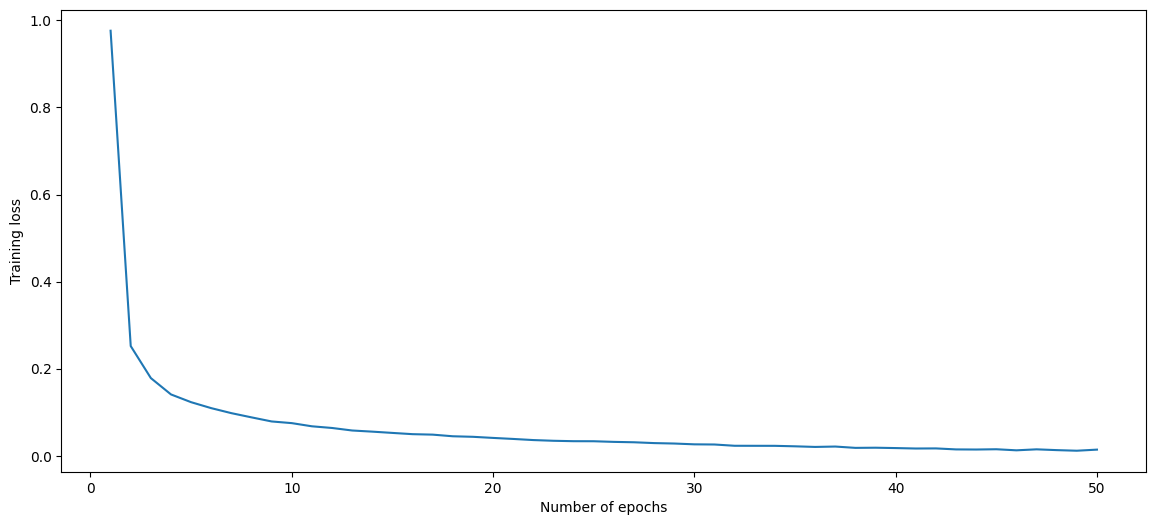

In [ ]:
# Train and evaluate CNN-Vanilla
print("Training CNN-Vanilla:")
train_losses_vanilla=train(cnn_vanilla, criterion, optimizer_vanilla, train_loader,epochs)
print("Evaluation CNN-Vanilla:")
evaluate(cnn_vanilla, test_loader)

plt.plot(range(1,epochs+1), train_losses_vanilla)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


Train and evaluate CNN-ResNet

Training CNN-ResNet:
Epoch 1/50, Loss: 0.805587647760168
Epoch 2/50, Loss: 0.20229874332534506
Epoch 3/50, Loss: 0.13277557045221328
Epoch 4/50, Loss: 0.10319299786648851
Epoch 5/50, Loss: 0.08892580573546126
Epoch 6/50, Loss: 0.07734136969802227
Epoch 7/50, Loss: 0.07084020578322259
Epoch 8/50, Loss: 0.06260268652534232
Epoch 9/50, Loss: 0.059412377434683604
Epoch 10/50, Loss: 0.056660340203249705
Epoch 11/50, Loss: 0.05424518617305984
Epoch 12/50, Loss: 0.049169216144512945
Epoch 13/50, Loss: 0.04833057006385098
Epoch 14/50, Loss: 0.04361765031167801
Epoch 15/50, Loss: 0.042441547511422886
Epoch 16/50, Loss: 0.0398213991578272
Epoch 17/50, Loss: 0.03723645491842577
Epoch 18/50, Loss: 0.03605773919162915
Epoch 19/50, Loss: 0.034211552940665725
Epoch 20/50, Loss: 0.03265385717312072
Epoch 21/50, Loss: 0.03231986639030436
Epoch 22/50, Loss: 0.03136911250730144
Epoch 23/50, Loss: 0.029832398805252097
Epoch 24/50, Loss: 0.02851523892914361
Epoch 25/50, Loss: 0.02579776517888333
Epoch 26/5

Text(0, 0.5, 'Training loss')

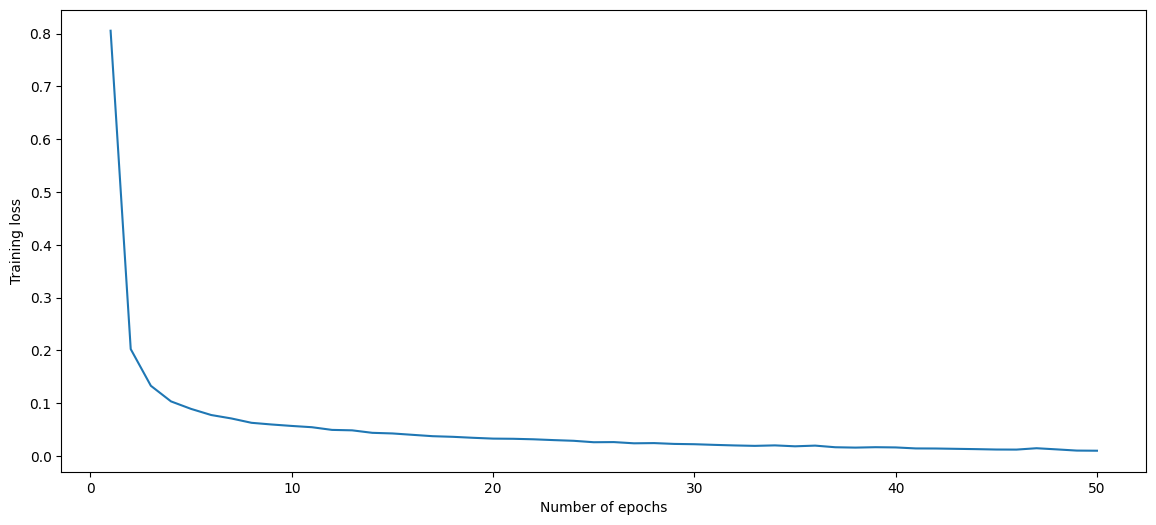

In [ ]:
# Train and evaluate CNN-ResNet
print("Training CNN-ResNet:")
train_losses_resnet=train(cnn_resnet, criterion, optimizer_resnet, train_loader,epochs)
print("Evaluation CNN-ResNet:")
evaluate(cnn_resnet, test_loader)

plt.plot(range(1,epochs+1), train_losses_resnet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

So we see that accuracy of Resnet model is better than CNN-Vanilla.Hence we will use ResNet as our model for performing the other experiments.

Experiment 2: Study the Effect of Data Normalization

Finding mean and std to normalise dataset

In [ ]:
pixel_values = []

# Iterate through the dataset to collect pixel values
for image, label in train_data:
    pixel_values.append(image.numpy())

# Convert list to numpy array
pixel_values = np.array(pixel_values)

# Compute mean and standard deviation along each channel (assuming grayscale images)
mean = np.mean(pixel_values)
std = np.std(pixel_values)

In [ ]:
transform_with_normalization = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_dataN = datasets.MNIST(root='./data', train=True, download=True, transform=transform_with_normalization)
test_dataN = datasets.MNIST(root='./data', train=False, download=True, transform=transform_with_normalization)  # Using normalization

# with Normalisation
batch_size=256
train_loaderN = torch.utils.data.DataLoader(train_dataN, shuffle=True, batch_size=batch_size)
test_loaderN = torch.utils.data.DataLoader(test_dataN, batch_size=batch_size)

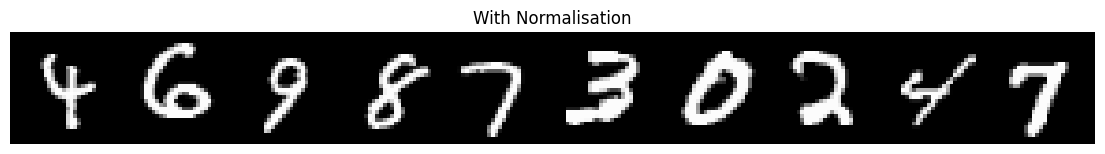

In [ ]:
plt.rcParams['figure.figsize'] = 14, 6

dataiter = iter(train_loaderN)
X, y = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
  X[:10], normalize=True, padding=1, nrow=10).numpy(), (1, 2, 0)))
plt.axis('off')
plt.title('With Normalisation')
plt.show()

Training and evaluating Normalised dataset

Training CNN-ResNet:


Epoch 1/50, Loss: 0.6484024709209483
Epoch 2/50, Loss: 0.14702002881689274
Epoch 3/50, Loss: 0.10393430898164181
Epoch 4/50, Loss: 0.08318741839141287
Epoch 5/50, Loss: 0.07060179858607181
Epoch 6/50, Loss: 0.06307626355518686
Epoch 7/50, Loss: 0.0553758335517759
Epoch 8/50, Loss: 0.05297935221423494
Epoch 9/50, Loss: 0.048595332025371966
Epoch 10/50, Loss: 0.042626540909739254
Epoch 11/50, Loss: 0.039872268928175275
Epoch 12/50, Loss: 0.03768440044703002
Epoch 13/50, Loss: 0.035619099608602676
Epoch 14/50, Loss: 0.03389414274629126
Epoch 15/50, Loss: 0.03248360952005742
Epoch 16/50, Loss: 0.02972621902863079
Epoch 17/50, Loss: 0.02867700754209085
Epoch 18/50, Loss: 0.02614593227057064
Epoch 19/50, Loss: 0.02453864065910432
Epoch 20/50, Loss: 0.025388863275540952
Epoch 21/50, Loss: 0.02251039818028345
Epoch 22/50, Loss: 0.022663360712257153
Epoch 23/50, Loss: 0.02107475284992301
Epoch 24/50, Loss: 0.01985214458768593
Epoch 25/50, Loss: 0.017650683222715048
Epoch 26/50, Loss: 0.01941754

Text(0, 0.5, 'Training loss')

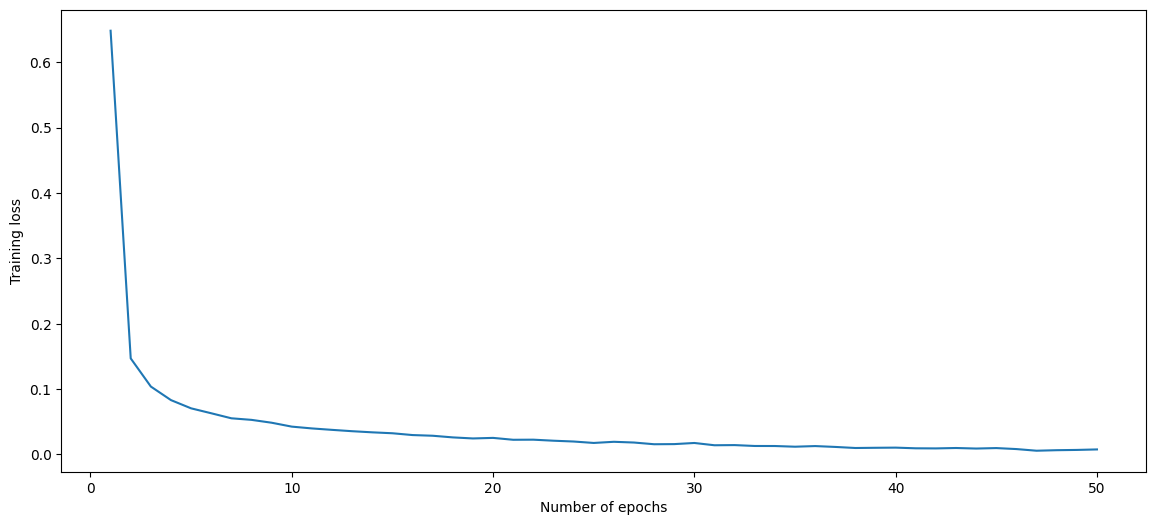

In [ ]:
# Train and evaluate CNN-ResNet
cnn_resnetN = CNN_ResNet()
cnn_resnetN = cnn_resnetN.to('cuda')

optimizer_resnetN = optim.Adam(cnn_resnetN.parameters(), lr=0.001)
print("Training CNN-ResNet:")
train_losses_resnetN=train(cnn_resnetN, criterion, optimizer_resnetN, train_loaderN,epochs)
print("Evaluation CNN-ResNet:")
evaluate(cnn_resnetN, test_loaderN)

plt.plot(range(1,epochs+1), train_losses_resnetN)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

Experiment 3: Comparing with different optimizers
(a) Mini-batch gradient descent with no momentum, (b)
Mini-batch gradient descent with momentum 0.9, and (c) ADAM optimizer.

In [ ]:
import torch.optim as optim

# Define the best-performing network architecture and the chosen data normalization technique
cnn_sgd = CNN_ResNet()
cnn_sgd_momentum = CNN_ResNet()
cnn_adam = CNN_ResNet()

# Move the networks to the GPU
cnn_sgd = cnn_sgd.to('cuda')
cnn_sgd_momentum = cnn_sgd_momentum.to('cuda')
cnn_adam = cnn_adam.to('cuda')

batch_size_large=512
train_loaderN_large = torch.utils.data.DataLoader(train_dataN, shuffle=True, batch_size=batch_size)
test_loaderN_large = torch.utils.data.DataLoader(test_dataN, batch_size=batch_size)

# Define the three optimizers
optimizer_no_momentum = optim.SGD(cnn_sgd.parameters(), lr=0.001)
optimizer_momentum = optim.SGD(cnn_sgd_momentum.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = optim.Adam(cnn_adam.parameters(), lr=0.001)

Training and evaluating Mini-batch gradient descent (no momentum)

In [ ]:
# Train the network with each optimizer
print("Training with Mini-batch gradient descent (no momentum):")
train_loss_sgd = train(cnn_sgd, criterion, optimizer_no_momentum, train_loaderN,epochs)

print("\nEvaluation on test set:")
print("Mini-batch gradient descent (no momentum):")
evaluate(cnn_sgd, test_loaderN)

Training with Mini-batch gradient descent (no momentum):


Epoch 1/50, Loss: 2.3051189077661394
Epoch 2/50, Loss: 2.251205005037024
Epoch 3/50, Loss: 2.2141021515460726
Epoch 4/50, Loss: 2.175894077788008
Epoch 5/50, Loss: 2.1302180919241396
Epoch 6/50, Loss: 2.072172954234671
Epoch 7/50, Loss: 1.996814801337871
Epoch 8/50, Loss: 1.8990167922161996
Epoch 9/50, Loss: 1.7755892418800516
Epoch 10/50, Loss: 1.6267614684206375
Epoch 11/50, Loss: 1.4573340324645347
Epoch 12/50, Loss: 1.2770408594861944
Epoch 13/50, Loss: 1.0961448732842791
Epoch 14/50, Loss: 0.9304797474374162
Epoch 15/50, Loss: 0.7927686384383669
Epoch 16/50, Loss: 0.6849908368384584
Epoch 17/50, Loss: 0.6033082286094097
Epoch 18/50, Loss: 0.5404425501823426
Epoch 19/50, Loss: 0.49029789503584514
Epoch 20/50, Loss: 0.44969758695744455
Epoch 21/50, Loss: 0.4159506599953834
Epoch 22/50, Loss: 0.3869010345732912
Epoch 23/50, Loss: 0.36220293666454073
Epoch 24/50, Loss: 0.341105761299742
Epoch 25/50, Loss: 0.3224016951119646
Epoch 26/50, Loss: 0.3063670238281818
Epoch 27/50, Loss: 0.29

Training and evaluating Mini-batch gradient descent (momentum 0.9)

In [ ]:
print("\nTraining with Mini-batch gradient descent (momentum 0.9):")
train_loss_sgd_momentum = train(cnn_sgd_momentum, criterion, optimizer_momentum, train_loaderN_large, epochs)

print("\nEvaluation on test set:")
print("\nMini-batch gradient descent (momentum 0.9):")
evaluate(cnn_sgd_momentum, test_loaderN)



Training with Mini-batch gradient descent (momentum 0.9):
Epoch 1/50, Loss: 1.928415032650562
Epoch 2/50, Loss: 0.5726541136173492
Epoch 3/50, Loss: 0.2731964146203183
Epoch 4/50, Loss: 0.20458849541684415
Epoch 5/50, Loss: 0.1744706243593642
Epoch 6/50, Loss: 0.15218398591622392
Epoch 7/50, Loss: 0.13721647576448764
Epoch 8/50, Loss: 0.12442149668931961
Epoch 9/50, Loss: 0.11674724046854262
Epoch 10/50, Loss: 0.10794029096339611
Epoch 11/50, Loss: 0.102811378700302
Epoch 12/50, Loss: 0.09715269709679675
Epoch 13/50, Loss: 0.09242836939210587
Epoch 14/50, Loss: 0.0876563668647345
Epoch 15/50, Loss: 0.08434116302969608
Epoch 16/50, Loss: 0.08073519697373217
Epoch 17/50, Loss: 0.07926243925665287
Epoch 18/50, Loss: 0.07535338736277945
Epoch 19/50, Loss: 0.07230698136573142
Epoch 20/50, Loss: 0.07086031837190719
Epoch 21/50, Loss: 0.06939682037113828
Epoch 22/50, Loss: 0.06605454387658453
Epoch 23/50, Loss: 0.06491129166109764
Epoch 24/50, Loss: 0.06350759337557123
Epoch 25/50, Loss: 0.0

Training and evaluating Adam optimizer

In [ ]:
print("\nEvaluation on test set:")
print("\nTraining with Adam optimizer:")
train_loss_adam = train(cnn_adam, criterion, optimizer_adam, train_loaderN_large,epochs)

print("\nAdam optimizer:")
evaluate(cnn_adam, test_loaderN)


Evaluation on test set:

Training with Adam optimizer:
Epoch 1/50, Loss: 0.6073090026036222
Epoch 2/50, Loss: 0.144256937361144
Epoch 3/50, Loss: 0.10554063654643424
Epoch 4/50, Loss: 0.08645783526466248
Epoch 5/50, Loss: 0.07735604942637556
Epoch 6/50, Loss: 0.07012732576658116
Epoch 7/50, Loss: 0.06283265582107483
Epoch 8/50, Loss: 0.05691362143038435
Epoch 9/50, Loss: 0.05310243894445135
Epoch 10/50, Loss: 0.04829589892575081
Epoch 11/50, Loss: 0.04688991438201133
Epoch 12/50, Loss: 0.042404023427119915
Epoch 13/50, Loss: 0.03910866347636948
Epoch 14/50, Loss: 0.03684321497269767
Epoch 15/50, Loss: 0.03674800278163178
Epoch 16/50, Loss: 0.034453679349749015
Epoch 17/50, Loss: 0.03068767506331998
Epoch 18/50, Loss: 0.030051653518123514
Epoch 19/50, Loss: 0.029308441857946045
Epoch 20/50, Loss: 0.02637273715610834
Epoch 21/50, Loss: 0.028164375817125782
Epoch 22/50, Loss: 0.02422021493276066
Epoch 23/50, Loss: 0.02342410478344623
Epoch 24/50, Loss: 0.022886223826517768
Epoch 25/50, L

Plotting the losses corresponding to each optimiser

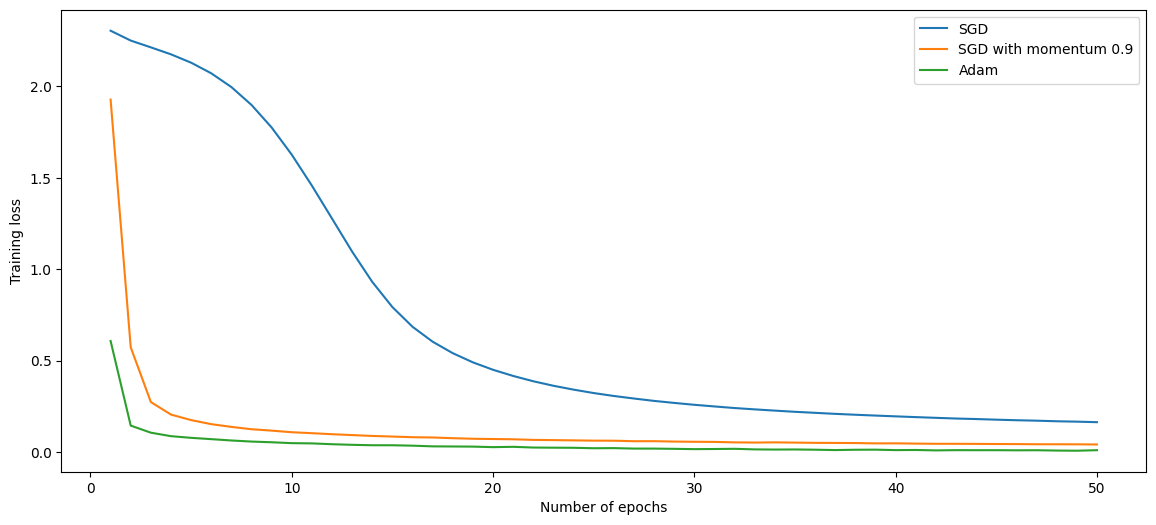

In [ ]:
# Plot the training loss for each optimizer
plt.plot(range(1,epochs+1), train_loss_sgd, label="SGD")
plt.plot(range(1,epochs+1), train_loss_sgd_momentum, label="SGD with momentum 0.9")
plt.plot(range(1,epochs+1), train_loss_adam, label="Adam")
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.legend()
plt.show()

EXPERIMENT 4

a) Modifying the ResNet from two level Resnet blocks with two fully-connected layers to Three level Resnet block with two fully-connected layers

In [ ]:
class CNN_ResNeta(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, n_channels=8):
        super(CNN_ResNeta, self).__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(in_channels,out_channels=n_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.resnet1 = ResidualBlock(n_channels, n_channels)
        self.resnet2 = ResidualBlock(n_channels, n_channels)
        self.resnet3 = ResidualBlock(n_channels, n_channels)
        self.fc_flat = nn.Flatten()     # ------> Flatten ----->
        self.fc_lin1 = nn.Linear(n_channels * 1* 1, 128)   #  ---------> Linear(512) ------>
        self.fc_relu = nn.ReLU()                #  ---------> ReLu ------->
        self.fc_lin2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.pool(self.resnet1(x))
        x = self.pool(self.resnet2(x))
        x = self.pool(self.resnet3(x))
        x = x.view(-1, self.n_channels * 1 * 1)   #flatten
        x = self.fc_lin1(x)
        x = self.fc_relu(x)
        x = self.fc_lin2(x)
        return x

resneta = CNN_ResNeta()
y_hat2 = resneta(images[0, :, :, :])
print(y_hat2.shape)

torch.Size([1, 10])


b) Modifying the ResNet from two level Resnet blocks with two fully-connected layers to Two level Resnet blocks with four
fully-connected layers

In [ ]:
class CNN_ResNetb(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, n_channels=8):
        super(CNN_ResNetb, self).__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(in_channels,out_channels=n_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.resnet1 = ResidualBlock(n_channels, n_channels)
        self.resnet2 = ResidualBlock(n_channels, n_channels)
        self.fc_flat = nn.Flatten()     # ------> Flatten ----->
        self.fc_lin1 = nn.Linear(n_channels * 3* 3, 128)   #  ---------> Linear(512) ------>
        self.fc_relu = nn.ReLU()
        self.fc_lin2 = nn.Linear(128, 64)
        self.fc_relu = nn.ReLU()
        self.fc_lin3 = nn.Linear(64, 32)
        self.fc_relu = nn.ReLU()
        self.fc_lin4 = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.pool(self.resnet1(x))
        x = self.pool(self.resnet2(x))
        x = x.view(-1, self.n_channels * 3 * 3)   #flatten
        x = self.fc_lin1(x)
        x = self.fc_relu(x)
        x = self.fc_lin2(x)
        x = self.fc_relu(x)
        x = self.fc_lin3(x)
        x = self.fc_relu(x)
        x = self.fc_lin4(x)
        return x

resnetb = CNN_ResNetb()
y_hat2 = resnetb(images[0, :, :, :])
print(y_hat2.shape)

torch.Size([1, 10])


In [ ]:
# Instantiate models
cnn_resneta = CNN_ResNeta()
cnn_resnetb = CNN_ResNetb()

cnn_resneta = cnn_resneta.to('cuda')
cnn_resnetb = cnn_resnetb.to('cuda')

# Define loss function and optimizer
epochs=50
criterion = nn.CrossEntropyLoss()
optimizer_resneta = optim.Adam(cnn_resneta.parameters(), lr=0.001)
optimizer_resnetb = optim.Adam(cnn_resnetb.parameters(), lr=0.001)

No of parameter in the model and model summary

In [ ]:
from torchsummary import summary

total_params = sum(p.numel() for p in cnn_resneta.parameters())
print(f"Total number of parameters for CNN-Resnet Part a : {total_params}")
summary(cnn_resneta, (1, 28, 28))

total_params = sum(p.numel() for p in cnn_resnetb.parameters())
print(f"Total number of parameters for CNN-Resnet Part b: {total_params}")
summary(cnn_resnetb, (1, 28, 28))

Total number of parameters for CNN-Resnet Part a : 6026
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
         MaxPool2d-2            [-1, 8, 14, 14]               0
              ReLU-3            [-1, 8, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]             584
              ReLU-5            [-1, 8, 14, 14]               0
            Conv2d-6            [-1, 8, 14, 14]             584
              ReLU-7            [-1, 8, 14, 14]               0
     ResidualBlock-8            [-1, 8, 14, 14]               0
         MaxPool2d-9              [-1, 8, 7, 7]               0
           Conv2d-10              [-1, 8, 7, 7]             584
             ReLU-11              [-1, 8, 7, 7]               0
           Conv2d-12              [-1, 8, 7, 7]             584
             ReLU-13              [-1, 8, 7, 7]

Training CNN-ResNet PART A:
Epoch 1/50, Loss: 1.0014464392306957
Epoch 2/50, Loss: 0.2912398382704309
Epoch 3/50, Loss: 0.194161604408254
Epoch 4/50, Loss: 0.15233091127048148
Epoch 5/50, Loss: 0.1265899694029321
Epoch 6/50, Loss: 0.10749039187076244
Epoch 7/50, Loss: 0.09731506359703998
Epoch 8/50, Loss: 0.09297700491832926
Epoch 9/50, Loss: 0.08406925103924376
Epoch 10/50, Loss: 0.0777910570039394
Epoch 11/50, Loss: 0.07159972660084989
Epoch 12/50, Loss: 0.06824770229769514
Epoch 13/50, Loss: 0.06523650754639443
Epoch 14/50, Loss: 0.0633605286360104
Epoch 15/50, Loss: 0.059003287181258204
Epoch 16/50, Loss: 0.0552085664083666
Epoch 17/50, Loss: 0.05252900993491107
Epoch 18/50, Loss: 0.05189536445714692
Epoch 19/50, Loss: 0.05015117236353615
Epoch 20/50, Loss: 0.04815537022387094
Epoch 21/50, Loss: 0.04970740781343998
Epoch 22/50, Loss: 0.04389332658710315
Epoch 23/50, Loss: 0.044046681952920365
Epoch 24/50, Loss: 0.04278556890785694
Epoch 25/50, Loss: 0.041600161874072346
Epoch 26/50

Text(0, 0.5, 'Training loss')

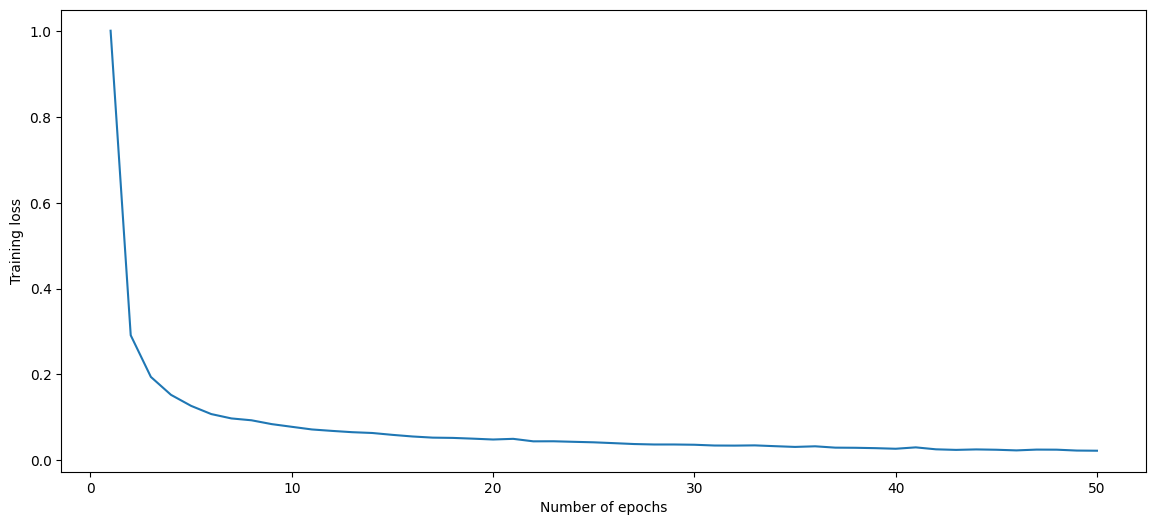

In [ ]:
# Train and evaluate CNN-ResNet
print("Training CNN-ResNet PART A:")
train_losses_resneta=train(cnn_resneta, criterion, optimizer_resneta, train_loader,epochs)
print("Evaluation CNN-ResNet PART A:")
evaluate(cnn_resnet, test_loader)

plt.plot(range(1,epochs+1), train_losses_resneta)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

Training CNN-ResNet PART B:


Epoch 1/50, Loss: 1.0827998600107558
Epoch 2/50, Loss: 0.2856598934594621
Epoch 3/50, Loss: 0.16145529842123071
Epoch 4/50, Loss: 0.12255700937610992
Epoch 5/50, Loss: 0.10404094104120072
Epoch 6/50, Loss: 0.08982029188662133
Epoch 7/50, Loss: 0.08216793337400924
Epoch 8/50, Loss: 0.0730063407979113
Epoch 9/50, Loss: 0.06772615613931036
Epoch 10/50, Loss: 0.06220176783885727
Epoch 11/50, Loss: 0.06003883671253286
Epoch 12/50, Loss: 0.057260573108462574
Epoch 13/50, Loss: 0.0513886413279366
Epoch 14/50, Loss: 0.05005850527197757
Epoch 15/50, Loss: 0.048080745291836716
Epoch 16/50, Loss: 0.045709623681738025
Epoch 17/50, Loss: 0.04058915986580418
Epoch 18/50, Loss: 0.03950802287324629
Epoch 19/50, Loss: 0.03932156174225693
Epoch 20/50, Loss: 0.03718476708027277
Epoch 21/50, Loss: 0.0370143132304099
Epoch 22/50, Loss: 0.03262847155887396
Epoch 23/50, Loss: 0.03156686909100477
Epoch 24/50, Loss: 0.032158281544144164
Epoch 25/50, Loss: 0.0296040799775894
Epoch 26/50, Loss: 0.028053621674313

Text(0, 0.5, 'Training loss')

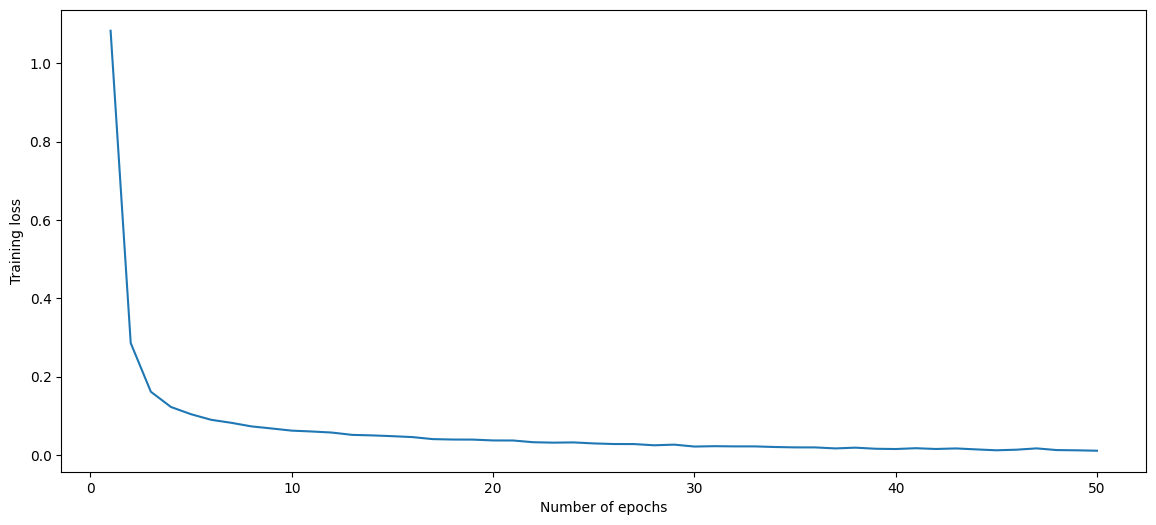

In [ ]:
# Train and evaluate CNN-ResNet
print("Training CNN-ResNet PART B:")
train_losses_resnetb=train(cnn_resnetb, criterion, optimizer_resnetb, train_loader,epochs)
print("Evaluation CNN-ResNet PART B:")
evaluate(cnn_resnet, test_loader)

plt.plot(range(1,epochs+1), train_losses_resnetb)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

Experiment 5: Study the Effect of Different Regularizers.Consider the following regularizers: (a) Batch Normalization, (b) Dropout, (c)
Both Batch Normalization and Dropout.

Modified CNN_Resnet

In [ ]:
import torch.nn.functional as F

class ResidualBlockNew(nn.Module):
    def __init__(self, in_channels, out_channels, use_batch_norm=False, use_dropout=False):
        super(ResidualBlockNew, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)
        if self.use_dropout:
            self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.relu(self.conv2(x))
        if self.use_batch_norm:
            x = self.bn2(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = x + residual  # Shortcut connection
        x = self.relu(x)
        return x

class CNN_ResNetNew(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, use_batch_norm=False, use_dropout=False, n_channels=8):
        super(CNN_ResNetNew, self).__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(in_channels,out_channels=n_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.resnet1 = ResidualBlockNew(n_channels, n_channels, use_batch_norm=use_batch_norm, use_dropout=use_dropout)
        self.resnet2 = ResidualBlockNew(n_channels, n_channels, use_batch_norm=use_batch_norm, use_dropout=use_dropout)
        self.fc_flat = nn.Flatten()
        self.fc_lin1 = nn.Linear(n_channels * 3* 3, 128)
        self.fc_relu = nn.ReLU()
        self.fc_lin2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.pool(self.resnet1(x))
        x = self.pool(self.resnet2(x))
        x = x.view(-1, self.n_channels * 3 * 3)
        x = self.fc_lin1(x)
        x = self.fc_relu(x)
        x = self.fc_lin2(x)
        return x


Models and optimizers

In [ ]:
# with Batch Normalization
resnet_with_batch_norm = CNN_ResNetNew(use_batch_norm=True)
resnet_with_batch_norm = resnet_with_batch_norm.to('cuda')

# with Dropout
resnet_with_dropout = CNN_ResNetNew(use_dropout=True)
resnet_with_dropout = resnet_with_dropout.to('cuda')

# with both Batch Normalization and Dropout
resnet_with_batch_norm_dropout = CNN_ResNetNew(use_batch_norm=True, use_dropout=True)
resnet_with_batch_norm_dropout = resnet_with_batch_norm_dropout.to('cuda')

optimizer_adam_bn= optim.Adam(resnet_with_batch_norm.parameters(), lr=0.001)
optimizer_adam_d= optim.Adam(resnet_with_dropout.parameters(), lr=0.001)
optimizer_adam_bnd= optim.Adam(resnet_with_batch_norm_dropout.parameters(), lr=0.001)


Training CNN_ResNet with Batch Normalisation

Training CNN-ResNet with batch normalisation:
Epoch 1/50, Loss: 0.3790447359706493
Epoch 2/50, Loss: 0.0801699254899583
Epoch 3/50, Loss: 0.06165989764985886
Epoch 4/50, Loss: 0.05000122404122289
Epoch 5/50, Loss: 0.04366818060900303
Epoch 6/50, Loss: 0.0393985482289436
Epoch 7/50, Loss: 0.034625770547922624
Epoch 8/50, Loss: 0.03169367125733419
Epoch 9/50, Loss: 0.0303114901752548
Epoch 10/50, Loss: 0.02739085231293389
Epoch 11/50, Loss: 0.024937564611157523
Epoch 12/50, Loss: 0.02258580492046523
Epoch 13/50, Loss: 0.021375893422977087
Epoch 14/50, Loss: 0.019733421064596225
Epoch 15/50, Loss: 0.018348625581216145
Epoch 16/50, Loss: 0.017115485034585792
Epoch 17/50, Loss: 0.016020117607463073
Epoch 18/50, Loss: 0.015232437736097169
Epoch 19/50, Loss: 0.01403815910923592
Epoch 20/50, Loss: 0.013373457318905027
Epoch 21/50, Loss: 0.012424735801462876
Epoch 22/50, Loss: 0.012081899362160487
Epoch 23/50, Loss: 0.011435333285678891
Epoch 24/50, Loss: 0.01031886404355433
Epoch 25/50, Loss: 

Text(0, 0.5, 'Training loss')

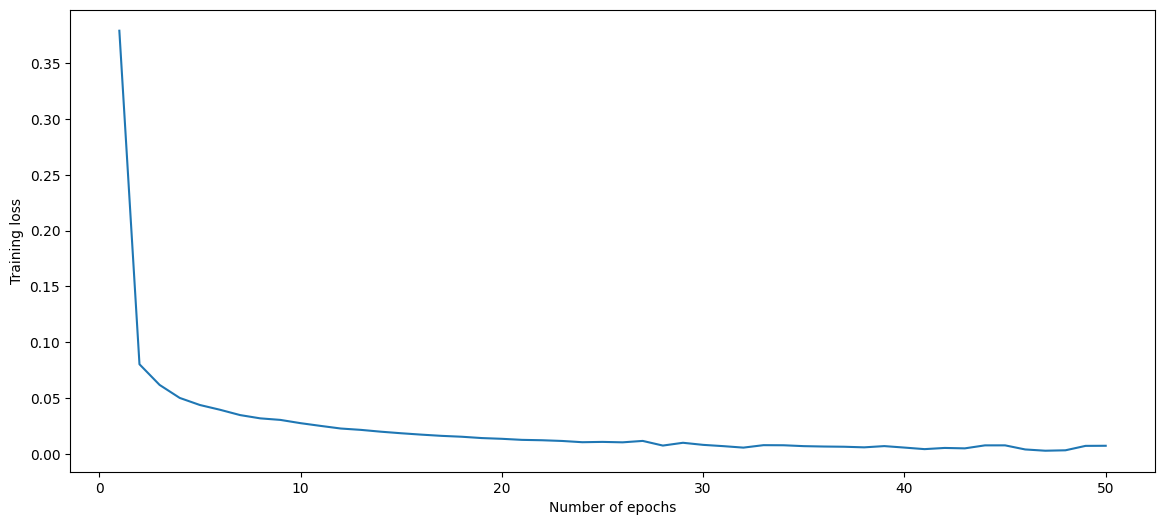

In [ ]:
print("Training CNN-ResNet with batch normalisation:")
train_lossesa=train(resnet_with_batch_norm, criterion, optimizer_adam_bn, train_loaderN,epochs)
print("Evaluation CNN-ResNet PART A:")
evaluate(resnet_with_batch_norm, test_loaderN)

plt.plot(range(1,epochs+1), train_lossesa)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

Training CNN-ResNet with dropout




Training CNN-ResNet with dropout:
Epoch 1/50, Loss: 0.6571810764835236
Epoch 2/50, Loss: 0.1986889033558521
Epoch 3/50, Loss: 0.15108177918702997
Epoch 4/50, Loss: 0.12917554470452858
Epoch 5/50, Loss: 0.11670822929194632
Epoch 6/50, Loss: 0.1085387073615764
Epoch 7/50, Loss: 0.10305495303361974
Epoch 8/50, Loss: 0.09461521049763294
Epoch 9/50, Loss: 0.08734844685234922
Epoch 10/50, Loss: 0.08548441245517832
Epoch 11/50, Loss: 0.07934926099124107
Epoch 12/50, Loss: 0.07749325940583615
Epoch 13/50, Loss: 0.07313774403263913
Epoch 14/50, Loss: 0.07096484458826958
Epoch 15/50, Loss: 0.06947712611724087
Epoch 16/50, Loss: 0.0683098186203774
Epoch 17/50, Loss: 0.06618495254599034
Epoch 18/50, Loss: 0.06300129495719646
Epoch 19/50, Loss: 0.05727721250992506
Epoch 20/50, Loss: 0.05710693451952427
Epoch 21/50, Loss: 0.05609601483224554
Epoch 22/50, Loss: 0.05703967824340501
Epoch 23/50, Loss: 0.05268480611687645
Epoch 24/50, Loss: 0.05215653414897462
Epoch 25/50, Loss: 0.05099965068016281
Epoc

Text(0, 0.5, 'Training loss')

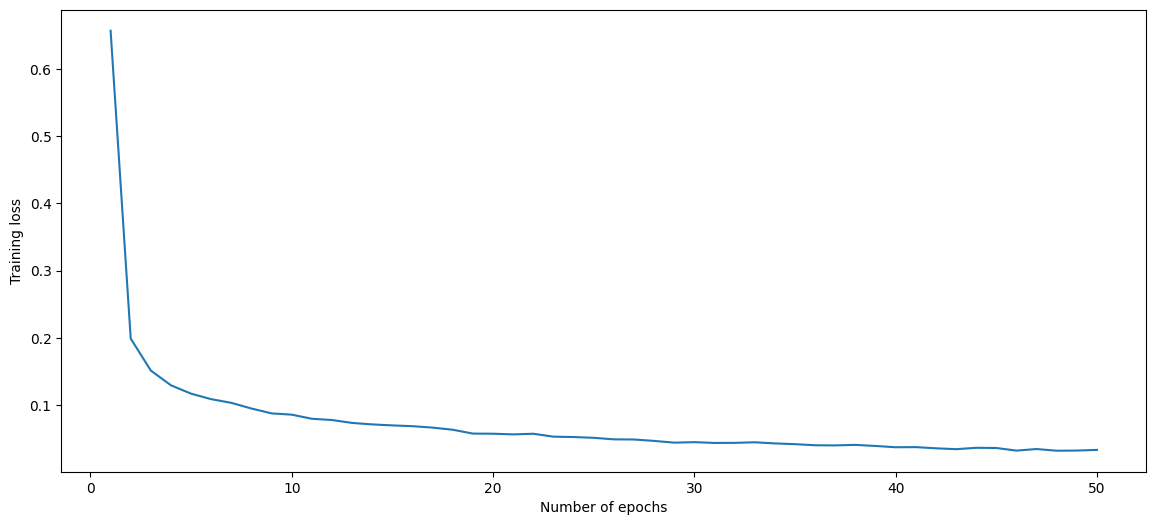

In [ ]:
print("Training CNN-ResNet with dropout:")
train_lossesb=train(resnet_with_dropout, criterion, optimizer_adam_d, train_loaderN,epochs)
print("Evaluation CNN-ResNet PART A:")
evaluate(resnet_with_dropout, test_loaderN)

plt.plot(range(1,epochs+1), train_lossesb)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

Training CNN-ResNet with dropout and batch norm



Training CNN-ResNet with dropout and batch norm:
Epoch 1/50, Loss: 0.5789327381456152
Epoch 2/50, Loss: 0.1540459338971909
Epoch 3/50, Loss: 0.11647601986819126
Epoch 4/50, Loss: 0.09639386600477898
Epoch 5/50, Loss: 0.08602759355401739
Epoch 6/50, Loss: 0.07294359640713702
Epoch 7/50, Loss: 0.0675905145110285
Epoch 8/50, Loss: 0.06277678172956122
Epoch 9/50, Loss: 0.05782856972135128
Epoch 10/50, Loss: 0.05519077599524184
Epoch 11/50, Loss: 0.05244276235474551
Epoch 12/50, Loss: 0.05148923553209356
Epoch 13/50, Loss: 0.04896592815267913
Epoch 14/50, Loss: 0.04695157576352358
Epoch 15/50, Loss: 0.04457515769816459
Epoch 16/50, Loss: 0.04300814203600934
Epoch 17/50, Loss: 0.040151738302108456
Epoch 18/50, Loss: 0.041285887283292855
Epoch 19/50, Loss: 0.04125227261176135
Epoch 20/50, Loss: 0.039225761998603316
Epoch 21/50, Loss: 0.036762547342384114
Epoch 22/50, Loss: 0.03640552310649543
Epoch 23/50, Loss: 0.03631485831190614
Epoch 24/50, Loss: 0.034497185603299355
Epoch 25/50, Loss: 0.0

Text(0, 0.5, 'Training loss')

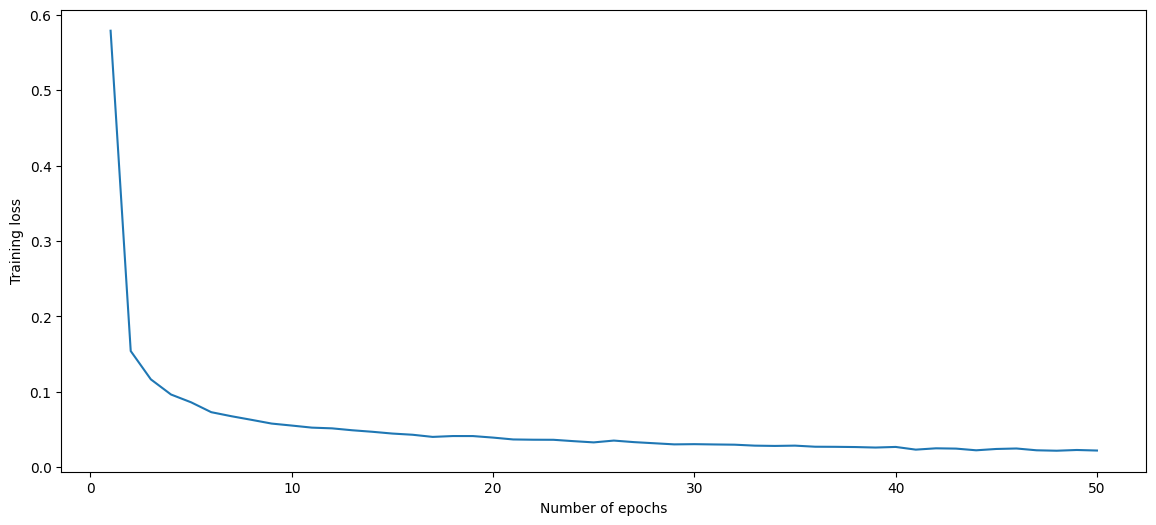

In [ ]:
print("Training CNN-ResNet with dropout and batch norm:")
train_lossesc=train(resnet_with_batch_norm_dropout, criterion, optimizer_adam_bnd, train_loaderN,epochs)
print("Evaluation CNN-ResNet PART A:")
evaluate(resnet_with_batch_norm_dropout, test_loaderN)

plt.plot(range(1,epochs+1), train_lossesc)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")